In [14]:
import numpy as np
from scipy.optimize import linear_sum_assignment 
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay
rng = np.random.default_rng(0)

# Step 1 : Role Assignment and Role-Adjacency Matrix Construction

In [15]:
def simulate_swap(T=300, sigma=0.5):
    # 6-role formation
    mu = np.array([
        [-8,  2], [-2, 2], [4, 2],
        [-4, -2], [2, -2],
        [0, -6]
    ])

    N = len(mu)
    X = np.zeros((T, N, 2))

    # players assigned fixed roles initially
    roles = np.arange(N)

    # choose two roles to swap
    k1, k2 = 3, 4

    for t in range(T):
        alpha = 0
        if T//3 <= t <= 2*T//3:
            alpha = (t - T//3) / (T//3)

        for i in range(N):
            k = roles[i]
            center = mu[k]

            # interpolate swap
            if k == k1:
                center = (1-alpha)*mu[k1] + alpha*mu[k2]
            if k == k2:
                center = (1-alpha)*mu[k2] + alpha*mu[k1]

            X[t, i] = center + sigma * rng.standard_normal(2)

    return X, mu

def em_hungarian(X, n_iter=20):
    T, N, _ = X.shape

    # init role means as mean of each player trajectory
    mu = X.mean(axis=0).copy()  # (N, 2)
    Sigma = np.array([np.eye(2) for _ in range(N)])

    assignments = np.zeros((T, N), dtype=int)

    for it in range(n_iter):
        # E-step: Hungarian per frame
        for t in range(T):
            cost = np.zeros((N, N))
            for i in range(N):
                for k in range(N):
                    diff = X[t, i] - mu[k]
                    cost[i, k] = diff @ diff  # squared distance
            row_ind, col_ind = linear_sum_assignment(cost)
            # row_ind should be [0..N-1] in order, but be safe
            assignments[t, row_ind] = col_ind

        # M-step: update mu
        for k in range(N):
            mask = assignments == k
            pts = X[mask]
            if len(pts) == 0:
                continue
            mu[k] = pts.mean(axis=0)

    return mu, assignments

In [16]:
# ----- Run experiment -----
X, mu_true = simulate_swap()
mu_est, roles_est = em_hungarian(X)

In [21]:
plot = False
if plot:
    colors = plt.cm.tab10(np.arange(6))
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    # Panel A: player ID coloring
    for i in range(6):
        axs[0].plot(X[:,i,0], X[:,i,1], color=colors[i], linewidth=1)
    axs[0].set_title("Trajectories colored by PLAYER ID")
    axs[0].axis("equal")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    # Panel B: role coloring
    for t in range(X.shape[0]):
        for i in range(6):
            k = roles_est[t,i]
            axs[1].scatter(X[t,i,0], X[t,i,1],
                        color=colors[k], s=3)

    axs[1].set_title("Same data colored by ROLE (EM+Hungarian)")
    axs[1].axis("equal")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    plt.tight_layout()


# Step 2 : Delanay Triangulation


In [18]:
def delaunay_adjacency(points):
    """
    Build symmetric adjacency matrix from Delaunay triangulation.
    """
    tri = Delaunay(points)
    N = len(points)
    A = np.zeros((N, N), dtype=int)

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i+1, 3):
                u, v = simplex[i], simplex[j]
                A[u, v] = 1
                A[v, u] = 1

    return A

In [ ]:
F442 = np.array([
    (-40,  20), (-40,   7), (-40,  -7), (-40, -20),   # Defenders (4)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,   8), ( 25,  -8)                            # Forwards (2)
])
F343 = np.array([
    (-40,  10), (-40,   0), (-40, -10),               # Defenders (3)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,  18), ( 25,   0), ( 25, -18)                # Forwards (3)
])
def simulate_roles(F1, F2, T=400, cp=200, sigma=2.0):
    """
    Simulates role trajectories with a single formation change.
    """
    N = len(F1)
    V = np.zeros((T, N, 2))

    for t in range(T):
        mu = F1 if t < cp else F2
        V[t] = mu + sigma * np.random.randn(N,2)

    return V

In [23]:
V = simulate_roles(F442,F343)
A = np.array([delaunay_adjacency(V[t]) for t in range(len(V))])

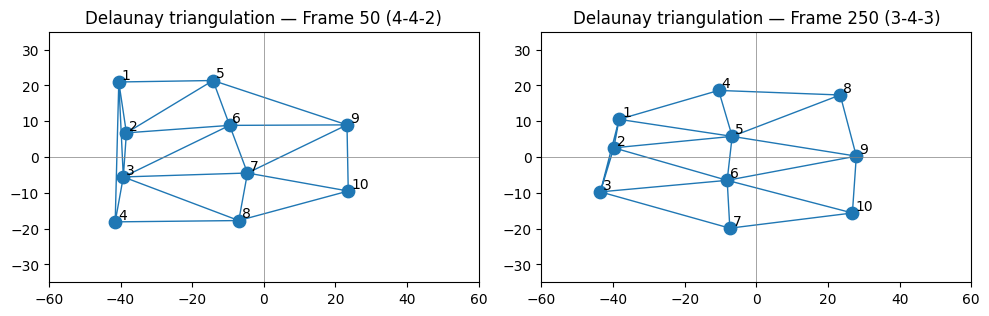

In [117]:
def plot_delaunay(ax, V_frame, title):
    tri = Delaunay(V_frame)
    ax.triplot(V_frame[:, 0],V_frame[:, 1],tri.simplices,lw=1)
    ax.scatter(V_frame[:, 0],V_frame[:, 1],s=80)

    for i, (x, y) in enumerate(V_frame):
        ax.text(x + 0.8, y + 0.8, str(i+1), fontsize=10)

    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)

    ax.set_xlim(-60, 60)
    ax.set_ylim(-35, 35)

    ax.set_aspect("equal")
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

plot_delaunay(ax[0], V[50],  "Delaunay triangulation — Frame 50 (4-4-2)")
plot_delaunay(ax[1], V[250], "Delaunay triangulation — Frame 250 (3-4-3)")

plt.tight_layout()
plt.savefig("report/figures/delany_form_change.png", dpi=250)

In [72]:
def plot_cmap(ax, A, title, cmap="Greys"):
    im = ax.imshow(
        A,
        vmin=0,
        vmax=1,
        cmap=cmap,
        interpolation="nearest"
    )
    ax.set_title(title, fontsize=11)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    return im

A_pre_frame   = A[0]      
A_post_frame  = A[200]   
A_pre_mean  = A[:200].mean(axis=0)
A_post_mean = A[200:].mean(axis=0)


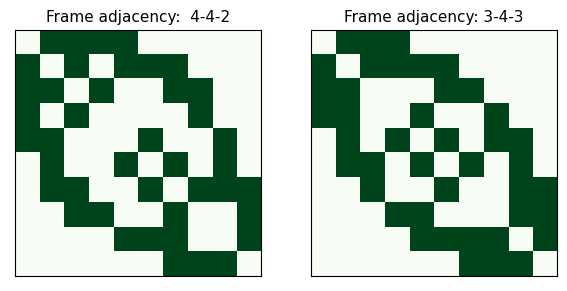

In [111]:
fig1, ax1 = plt.subplots(1, 2, figsize=(7,4))
plot_cmap(ax1[0], A[0],   "Frame adjacency:  4-4-2", cmap="Greens")
plot_cmap(ax1[1],A[200], "Frame adjacency: 3-4-3", cmap="Greens")
plt.savefig("report/figures/A_examples.png", dpi=250,bbox_inches="tight", pad_inches=0.02)

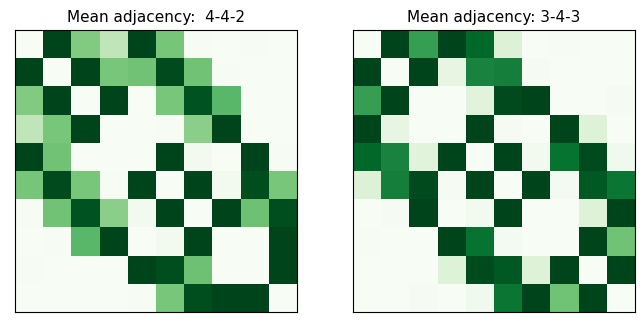

In [113]:
fig1, ax1 = plt.subplots(1, 2, figsize=(8,4))
im = plot_cmap(ax1[0], A_pre_mean,   "Mean adjacency:  4-4-2", cmap="Greens")
plot_cmap(ax1[1],A_post_mean, "Mean adjacency: 3-4-3", cmap="Greens")

plt.savefig("report/figures/A_mean.png", dpi=250,bbox_inches="tight", pad_inches=0.02)